## Q1: Problem of anomaly detection:You are given the dataset of networkuser activity, and the task is to classify each user activity as normal or an attack. (All parts in this notebook only).

### PART-1

#### Do dimensionality reduction using PCA on given dataset. Keep the tolerance of 10% (knee method), meaning reconstruction of the original data from the reduced dimensions in PCA space can be done with 10% error. 

In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
dataset = pd.read_csv("../input_data/data.csv")
target = 'xAttack'
new_target = dataset[target]
# print dataset.columns
col_list = dataset.columns[:-1]
print len(col_list)

29


standardise each col with its mean and std. returns the standardised df

In [3]:
def meanCentered(df):
    cols = df.columns
    
    for c in cols:
        if c != target:
            mean = df[c].mean()
            std = df[c].std()
#             print "c: ",c ,"mean: ",mean, " std: ",std
            df[c] = (df[c] - mean) / std
    return df
dataset = meanCentered(dataset)
# print dataset.head()


function makeX: makes a feature matrix without the target column. input: dataframe

In [4]:
def makeX(df):
    if target in df.columns:
        df = df.drop([target], axis=1)
    X = df.values
    return X
feature_mat = makeX(dataset)
print feature_mat.shape

(24998, 29)


function findCovarianceMatrix: finds the covariance matrix using 1/n-1 (X'X)

In [5]:
def findCovarianceMatrix(matrix):
    trans = matrix.transpose()
    rows = matrix.shape[0]
    cov = np.dot(trans, matrix) / (rows - 1)
    return cov
covariance = findCovarianceMatrix(feature_mat)
print covariance.shape
# print covariance

(29, 29)


function plotGraphs: plot graphs general

In [6]:
def plotGraphs(x,y,i, xaxis, yaxis):
    title = xaxis + " vs " + yaxis
    fig, axes = plt.subplots(figsize=(7, 7))
    axes.plot(x, y)
    axes.grid(True)
    axes.set_xlabel(xaxis)
    axes.set_ylabel(yaxis)
    axes.set_title(title)
    

function findEigen
- finds eigen values and vectors of covariance matrix 
- then find sum of all eigen values
- type('eigen vec') numpy array. ==> convert this to list
- make dictionary of the form { 'eigen val': 'eigen vec' } ==> convert this to ordered dict
- sort values in descending order
- find variance of eigen values
- find cumulative sum of eigen values : 'cs'
- choose the knee where 'cs' crosses 90%

In [7]:
def findEigen(mat):
    eigen_values, eigen_vec = np.linalg.eig(mat)
    # print eigen_values.shape, eigen_vec.shape
#     print "ev: ",eigen_values
#     print eigen_vec
    eigen_dic = {}
    sum_eigen = np.sum(eigen_values)
    
    print "sum: ",sum_eigen
    
    for i in range(len(eigen_values)):
    #     print "eigen_val: ",eigen_values[i]
        eigen_dic[eigen_values[i]] = [eigen_vec[i].tolist(), col_list[i]]
        od = collections.OrderedDict(sorted(eigen_dic.items(), reverse = True))
#     print od

    for ev in eigen_vec:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    print('Everything ok!')
    var_exp = [(i / sum_eigen) * 100 for i in od]
#     print "var: ",var_exp
    cum_var_exp = np.cumsum(var_exp)
#     print "cum: ",cum_var_exp
    xaxis = range(1,30)
#     print "var: ", var_exp
    
    plotGraphs(xaxis, cum_var_exp, 0, "pc", "var")
    
    
    return od

sum:  28.999999999999993
Everything ok!


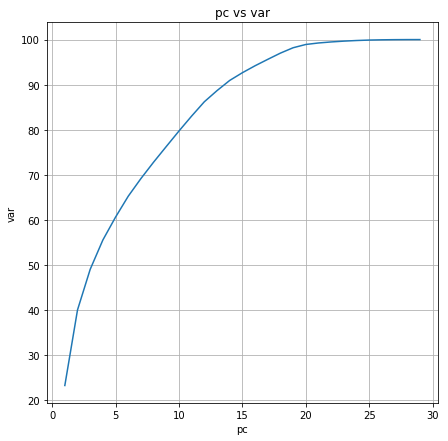

In [8]:
od = findEigen(covariance)
# print od


--> we see here 14 attributes give 90% variance. so k = 14

function findTopK:
- use the top k features of ordered dictionary
- use those top k eigen vectors

In [9]:
def findTopK(val_vec, k):
    #feature vector top 2
#     print "val_vec: ",val_vec, "K: ",k
    topK = {}
    topK = {key: val_vec[key] for key in val_vec.keys()[:k]}
    firstKPairs = collections.OrderedDict(sorted(topK.items(), reverse = True))
#     print "first ",k," pairs: ",firstKPairs
    featureEigen = []
    keys = []
    index = 0
    for k,v in firstKPairs.iteritems():
        keys.insert(index, k)
        index += 1
    print "keys: ", keys
    eigen_vector_list = []
    eigen_cols_list = []
    index = 0
    for k in keys:
        eig1 = firstKPairs[k][0]
        eigen_vector_list.insert(index, eig1)
        eigen_cols_list.insert(index, firstKPairs[k][1])
        index += 1
#     print "eigen_vector_list: ",eigen_vector_list
    print "len ",len(eigen_vector_list)
    print "eigen cols: ",eigen_cols_list
    eigen_vector_mat = np.array([np.array(li) for li in eigen_vector_list])
    print "eigen vector mat shape: ",eigen_vector_mat.shape
    return eigen_vector_mat, eigen_cols_list


featureVec, newFeatures = findTopK(od, 14)

keys:  [6.737650560412195, 4.863748658249224, 2.6129389091612407, 1.8881746586020167, 1.4723321327107877, 1.3444011113332424, 1.1368223634097065, 1.055949927810457, 1.0060196479827326, 0.9977071090833088, 0.9628462083068577, 0.9189949090877084, 0.7169687424702471, 0.6556967926094629]
len  14
eigen cols:  ['duration', 'service', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'srv_count', 'count', 'num_access_files', 'num_file_creations', 'serror_rate', 'srv_serror_rate']
eigen vector mat shape:  (14, 29)


function finalVector: finalData = featurVector * meanData

In [10]:
def finalVector(rowFeatureVector, rowZeroMeanData):
    
    rowZeroMeanData = rowZeroMeanData.transpose()
    finalData = np.dot(rowFeatureVector, rowZeroMeanData)
    return finalData

m = finalVector(featureVec, feature_mat)
print "m: ",m.shape

m:  (14, 24998)


### PART-2

#### Use the reduced dimensions from the first part and perform K-means clustering with k equal to five(number of classes in the data).  Also calculatethe purity of clusters with given class label.

In [11]:
def initializeK(finalData,k):
    col = finalData.shape[1]
    mean = np.mean(finalData, axis = 0)
    std = np.std(finalData, axis = 0)
    centers = np.random.randn(k,col)*std + mean
    print "centers: ",centers.shape
    return centers
clusters = 5
mat = m.transpose()
print "mat: ", mat.shape
centers = initializeK(mat, clusters)

mat:  (24998, 14)
centers:  (5, 14)


In [12]:
def addCluster(clist):
    global df
    for i in range(len(clist)):
        rowIndex = df.index[i]
        df.loc[rowIndex, 'cluster'] = clist[i]

In [13]:
def printDistribution(clist):
    unique, counts = np.unique(clist, return_counts=True)
    print dict(zip(unique, counts))

In [14]:
centers_old = np.zeros(centers.shape)
print "centers old: ",centers_old.shape
centers_new = deepcopy(centers)
print "centersnew : ",centers_new.shape
rows = m.shape[1] #249998
distances = np.zeros((rows, clusters))
print "dis: ",distances.shape
clusters_list = np.zeros(rows) #for all values, cluster is 0

centers old:  (5, 14)
centersnew :  (5, 14)
dis:  (24998, 5)


make a dataframe : 14 cols, 24998 rows

In [15]:
df = pd.DataFrame(m)
df = df.transpose()
df.columns = newFeatures #column list of 14 selected attr

In [16]:
iterations = 0
def expectationMaxim():
    while True:
        global centers_old, mat, centers_new, distances, iterations
       
        #compute distance of each data point to the center
        for c in range(clusters):
            #for each center, calculate distance to all points
            dis_vec = mat - centers_new[c]
            distances[:,c] = np.linalg.norm(dis_vec, axis = 1)
        
            #its center is the one for which min distance is found
            clusters_list = np.argmin(distances, axis = 1) #a list which stores centers of corressponding indices
        
        addCluster(clusters_list) #adds a column of 'cluster' in df and value is the cluster number assigned

        centers_old = deepcopy(centers_new)
        printDistribution(clusters_list) #prints the number of samples in 1 cluster
        
        #find mean of all cluster points
        #reassign centers
        for i in range(clusters):
            temp = df[df['cluster'] == i]
            clusters_i = temp.drop('cluster', axis = 1)
            centers_new[i] = np.mean(clusters_i, axis = 0)
         #find diff
        error = np.linalg.norm(centers_new - centers_old)
        iterations += 1
        print "iterations: ",iterations
        # repeat till diff is zero
        print "error: ",error
        if error == 0:
            break

In [17]:
expectationMaxim()

{0: 16085, 1: 7361, 2: 186, 3: 563, 4: 803}
iterations:  1
error:  12.398982384520652
{0: 14705, 1: 6921, 2: 158, 3: 924, 4: 2290}
iterations:  2
error:  2.879980277095895
{0: 13382, 1: 6918, 2: 156, 3: 991, 4: 3551}
iterations:  3
error:  1.7008227474200166
{0: 13897, 1: 6912, 2: 163, 3: 1056, 4: 2970}
iterations:  4
error:  1.789429806324192
{0: 13886, 1: 6910, 2: 165, 3: 1112, 4: 2925}
iterations:  5
error:  0.3407309846803259
{0: 13857, 1: 6910, 2: 166, 3: 1143, 4: 2922}
iterations:  6
error:  0.16092619290528473
{0: 13834, 1: 6910, 2: 166, 3: 1166, 4: 2922}
iterations:  7
error:  0.04947893994462185
{0: 13816, 1: 6910, 2: 166, 3: 1184, 4: 2922}
iterations:  8
error:  0.037929946678856435
{0: 13804, 1: 6910, 2: 166, 3: 1196, 4: 2922}
iterations:  9
error:  0.024750605386786587
{0: 13797, 1: 6910, 2: 166, 3: 1203, 4: 2922}
iterations:  10
error:  0.014497102376166044
{0: 13792, 1: 6910, 2: 166, 3: 1208, 4: 2922}
iterations:  11
error:  0.010389787920381473
{0: 13788, 1: 6910, 2: 166

In [18]:
# Data to plot
def plotPieChart(values, cluster_num, method):
            
    y=np.array(values)
    percent = 100.0*y/y.sum()
    legends = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(unique_attacks, percent)]
    
    with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.axis('equal')
        title = method + ": cluster no."+ str(cluster_num)
        ax.set_title(title)
        wedges, labels = ax.pie(y, shadow=True, startangle=90)
        wedges, legends, dummy =  zip(*sorted(zip(wedges, legends, y),key=lambda x: x[2],reverse=True))
        ax.legend(wedges, legends, loc='best', bbox_to_anchor=(-0.1, 1.),fontsize=12)


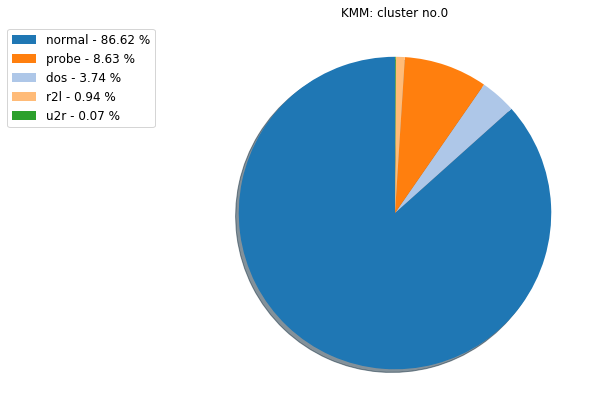

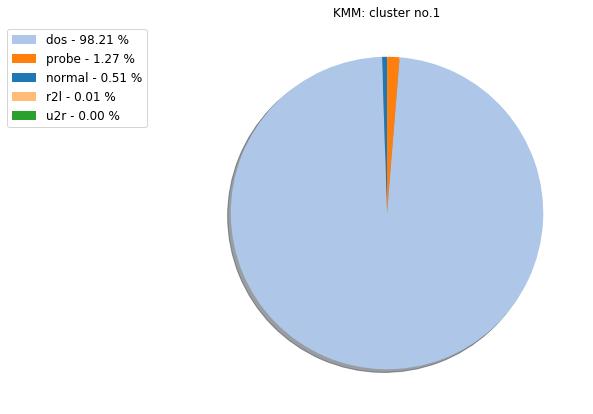

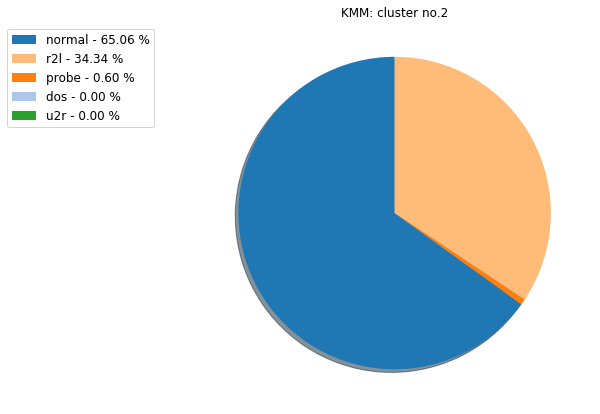

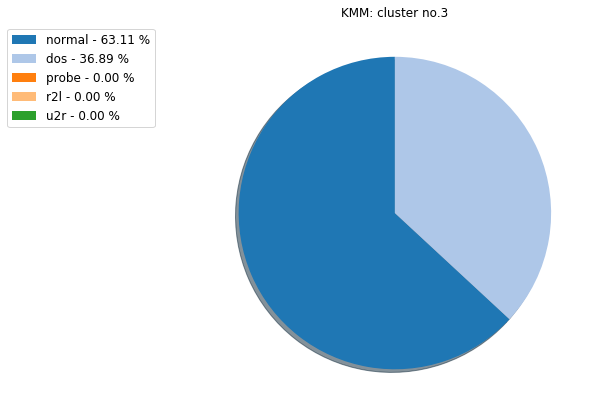

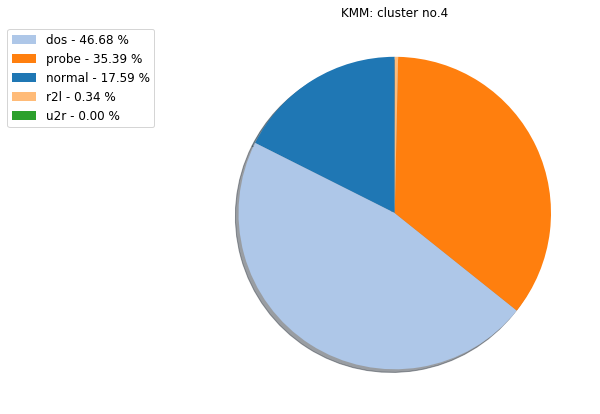

In [19]:
df['target'] = new_target
unique_attacks = new_target.unique()

def findFraction(method):
    cluster_f = []
    for i in range(clusters):
#         print "CLUSTER ",i
        this_cluster = df[df['cluster']== i]
        num_samples = this_cluster.shape[0]
        fraction_list = []
        for u in unique_attacks:
            count = this_cluster[this_cluster['target']==u].shape[0]
            fraction = float(count)/num_samples
        
#             print "Attack ",u, " is ", fraction*100, "% of this cluster"
            fraction_list.append(fraction*100)
#         print "----------"
        cluster_f.append(fraction_list)
        plotPieChart(fraction_list, i, method)
    return cluster_f
kmm = findFraction("KMM")

### PART-3

#### Perform GMM (with five Gaussian) on the reduced dimensionsfrom first part and calculate the purity of clusters

{0: 6464, 1: 6276, 2: 5360, 3: 1417, 4: 5481}


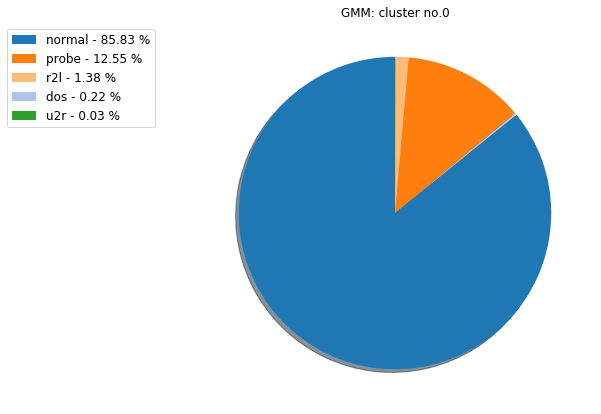

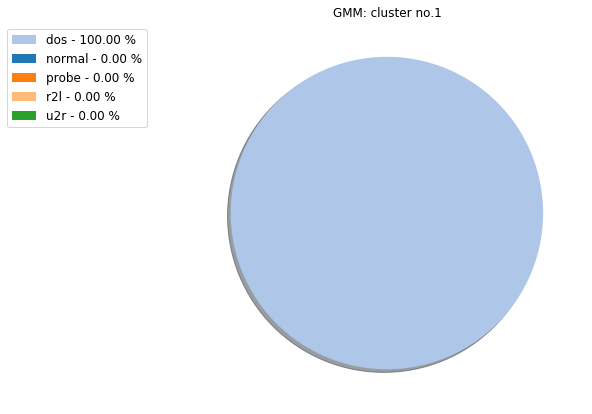

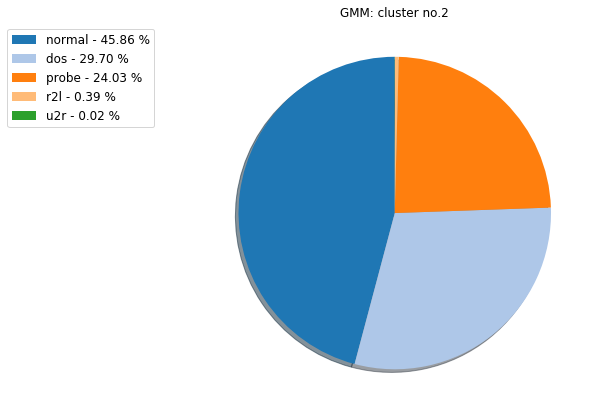

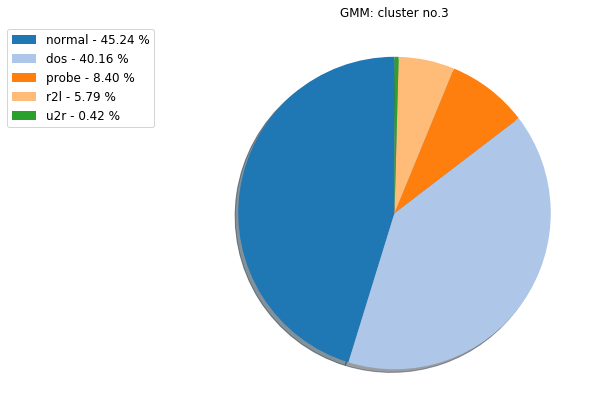

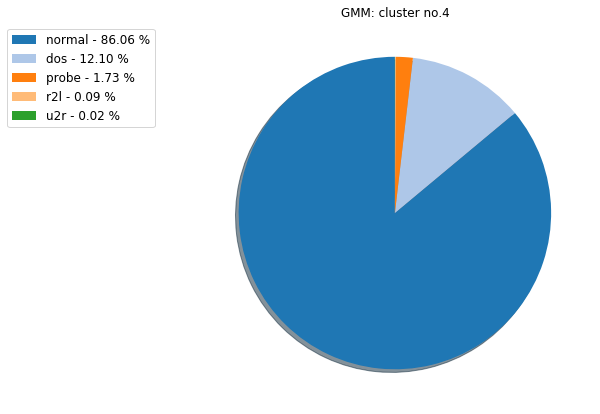

In [20]:
from sklearn.mixture import GaussianMixture
tempDF = df.drop(columns = ['cluster','target']).values
gmm = GaussianMixture(n_components=5).fit(tempDF)
labels = gmm.predict(tempDF)

# print "labels:",type(labels)
printDistribution(labels)
addCluster(labels)
gmm = findFraction("GMM")

### PART-4

#### Perform  Hierarchical  clustering  with  single-linkage  and  fiveclusters.  Also calculate the purity of clusters.  Create a pie chart comparing purityof different clustering methods you have tried for all classes

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'single')
test = mat[:20000,0:14]
tempDf = df.drop(columns = ['target'], axis = 1)
labels = cluster.fit_predict(test)

{0: 19993, 1: 4, 2: 1, 3: 1, 4: 1}


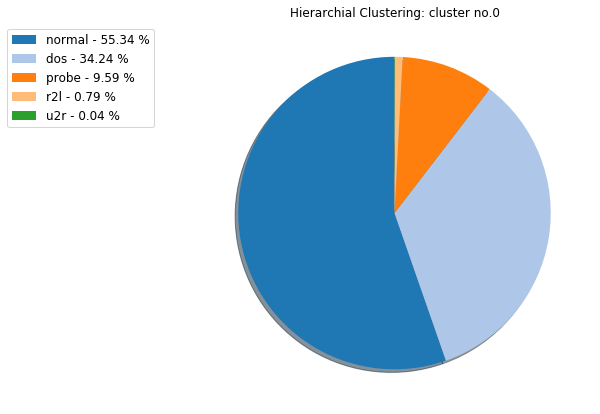

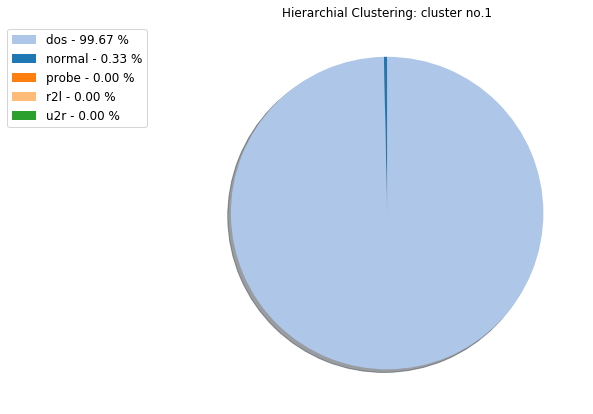

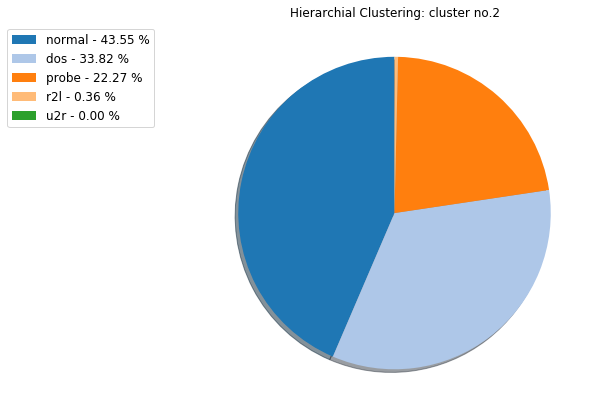

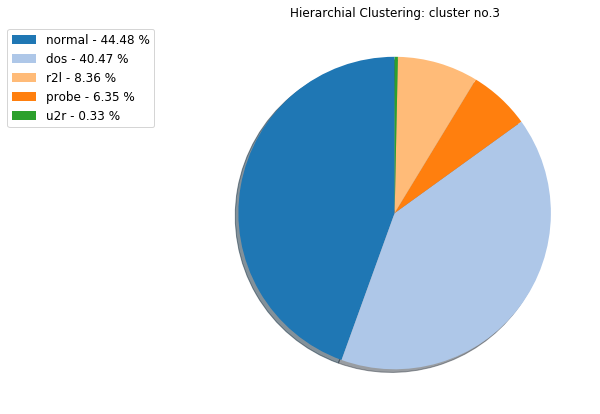

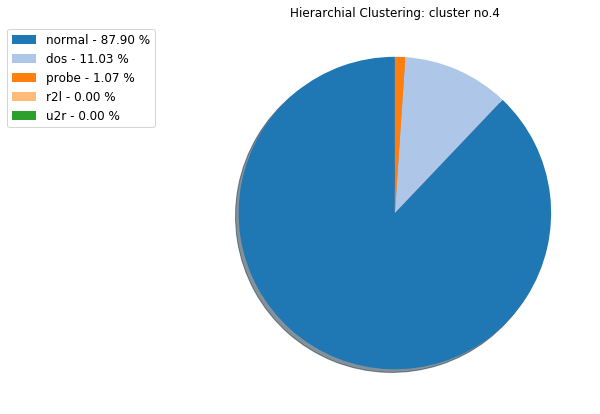

In [23]:
addCluster(labels)
printDistribution(labels)
hc = findFraction("Hierarchial Clustering")

### PART-5

#### If  you  were  to  do  dimensionality  reduction  on  originaldata, could you use PCA? Justify.  Write a paragraph in report for your explana-tion/justification

PCA works good for continuous variables. It minimizes variance; the concept of variance is not applicable for binary variables. Although we can apply PCA after converting the categorical attributes to nominal ones, the results are less meaningful. Also, finding distance between two categorical attributes is difficult. If categorical attributes are present, we should use Multiple Correspondence Analysis in place of PCA.
